In [1]:
import ppi_py as ppi
import numpy as np
import statsmodels as sm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

def simulate_ols_data(beta, ppi_corr, bias, n, N):
    """
    Simulate data for the OLS example

    Args:
        beta (ndarray): regression coefficients, shape d + 1
        ppi_corr (float): PPI correlation
        bias (float): bias to appl to all coefficients
        n (int): number of labeled samples
        N (int): number of unlabeled samples

    Returns:
        X (ndarray): covariates for labeled data , shape n x (d + 1)
        Y (ndarray): labels, shape n
        Yhat (ndarray): predictions on labeled data, shape n
        X_unlabeled (ndarray): covariates for unlabeled data, shape N x (d + 1)
        Yhat_unlabeled (ndarray): predictions on unlabeled data set shape N
    """

    d = len(beta) - 1

    X = np.random.normal(size=(n, d+1))/(d+1)**0.5
    X[:, 0] = 1

    X_unlabeled = np.random.normal(size=(N, d+1))/(d+1)**0.5
    X_unlabeled[:, 0] = 1

    max_ppi_corr = 1/(2*bias**2+1)**0.5
    max_bias = (0.5*((1/ppi_corr)**2 - 1))**0.5
    assert ppi_corr <= max_ppi_corr, f"ppi_corr must be less than {max_ppi_corr} or bias must be less than {max_bias}"

    rho = ppi_corr * (2*bias**2+1)**0.5

    Z = np.random.normal(size=n)
    Y = X @ beta + rho**0.5 * Z + (1 - rho) ** 0.5 * np.random.normal(size=n)
    Yhat = X @ (beta + bias) + rho**0.5 * Z + (1 - rho) ** 0.5 * np.random.normal(size=n)
    Yhat_unlabeled = X_unlabeled @ (beta + bias) + np.random.normal(size=N)

    return X, Y, Yhat, X_unlabeled, Yhat_unlabeled



(1000, 2)

In [31]:
# true intercept and slope
beta = np.ones(2)

# bias 
bias = 0.3

# PPI correlation
ppi_corr = 0.9
n = 1000
N = 100000
X, Y, Yhat, X_unlabeled, Yhat_unlabeled = simulate_ols_data(beta, ppi_corr, bias, n, N)

ppi_est = ppi.ppi_ols_pointestimate(X, Y, Yhat, X_unlabeled, Yhat_unlabeled)
print("PPI estimate:", ppi_est[1])

silicon_est = np.linalg.solve(X_unlabeled.T @ X_unlabeled, X_unlabeled.T @ Yhat_unlabeled)
print("Silicon estimate:", silicon_est[1])

silicon_est2 = sm.regression.linear_model.OLS(Yhat_unlabeled, X_unlabeled).fit().params
print("Silicon estimate 2:", silicon_est2[1])

PPI estimate: 0.9932893068400797
Silicon estimate: 1.296172939915467
Silicon estimate 2: 1.296172939915463


In [5]:
# true intercept and slope
beta = np.ones(2)

# bias 
bias = 0.3

# PPI correlation
ppi_corr = 0.9

# sample size human subjects
ns = [1000]

# multiples of human subjects sample size
ks = list([0.25, 0.5, 0.75]) + list(np.arange(1, 10.5, 0.5))

# sample size silicon subjects 
Ns = [int(n * k) for n in ns for k in ks]

# number of repetitions for combinations of n and N
reps = 10

# initialize list to collect results
results = []

# initialize a random number generator with a fixed seed for reproducibility
rng = np.random.default_rng(seed=20241026)

for r in range(reps):

  if (r+1) % 10 == 0 or r == 0:
    print(f"Repetition {r+1} out of {reps}")


  for n in ns:      

    for N in Ns:
      # simulate data
      X, Y, Yhat, X_unlabeled, Yhat_unlabeled = simulate_ols_data(beta, ppi_corr, bias, n, N)

      

      # get coefficient estimate from silicon sampling
      beta_sil = sm.regression.linear_model.OLS(Yhat_unlabeled, X_unlabeled).fit().params[1]


      # get coefficient estimate from mixed-subjects PPI
      beta_ppi = ppi.ppi_ols_pointestimate(
        X, 
        Y, 
        Yhat, 
        X_unlabeled, 
        Yhat_unlabeled)[1]

      # append the results to the list as a dictionary
      results.append({
          'beta_ppi': beta_ppi,
          'beta_sil': beta_sil,
          'n': n,
          'N': N,
          'rep': r+1
      })
  
# convert list of dictionaries to a pandas DataFrame
result_df = pd.DataFrame(results).sort_values(by=['rep', 'n', 'N'], ascending=True)

# (Optional) Display the first few rows of the DataFrame to verify
print(result_df.head(20))

Repetition 1 out of 10
Repetition 10 out of 10
    beta_ppi  beta_sil     n     N  rep
0   1.057330  1.185480  1000   250    1
1   0.989388  1.191813  1000   500    1
2   0.930999  1.268958  1000   750    1
3   1.035408  1.300815  1000  1000    1
4   0.959441  1.255509  1000  1500    1
5   1.024201  1.286983  1000  2000    1
6   0.997384  1.309664  1000  2500    1
7   1.000244  1.285818  1000  3000    1
8   1.022526  1.341589  1000  3500    1
9   1.028571  1.315824  1000  4000    1
10  0.956805  1.258786  1000  4500    1
11  1.023175  1.316563  1000  5000    1
12  1.022422  1.303258  1000  5500    1
13  1.005735  1.285628  1000  6000    1
14  0.978247  1.298934  1000  6500    1
15  1.004856  1.288883  1000  7000    1
16  1.000798  1.283416  1000  7500    1
17  0.989705  1.275774  1000  8000    1
18  1.010462  1.299876  1000  8500    1
19  1.022639  1.315337  1000  9000    1



Averaged Results by n and N:
      n     N  beta_ppi  beta_sil  bias_ppi  bias_sil
0  1000   250  1.007940  1.285287  0.007940  0.285287
1  1000   500  1.003748  1.286478  0.003748  0.286478
2  1000   750  0.995945  1.272773 -0.004055  0.272773
3  1000  1000  1.005890  1.298272  0.005890  0.298272
4  1000  1500  1.010309  1.324133  0.010309  0.324133


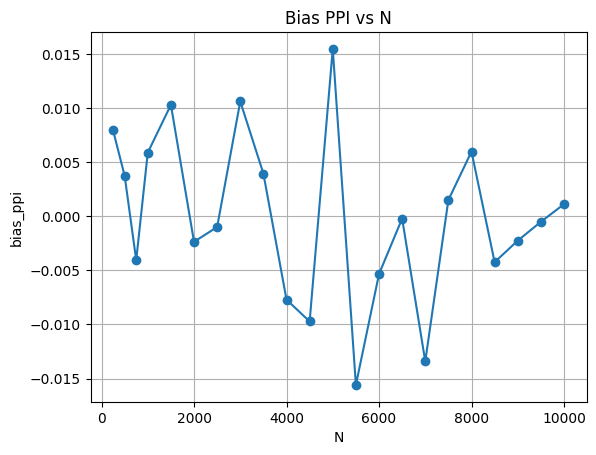

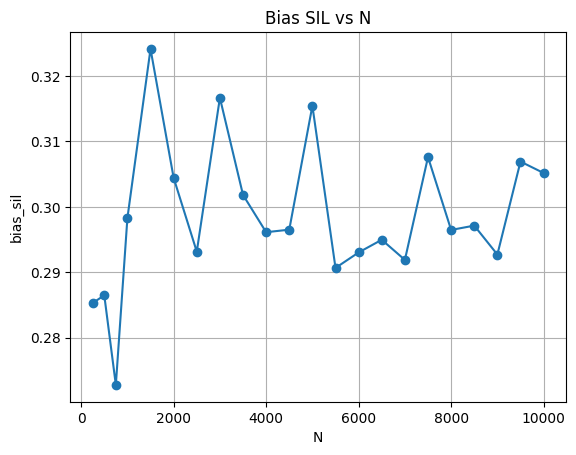

In [34]:
# Group by 'n' and 'N', then calculate the mean of 'beta_ppi' and 'beta_sil'
df = result_df.groupby(['n', 'N'])[['beta_ppi', 'beta_sil']].mean().reset_index()

# Calculate bias columns
df['bias_ppi'] = df['beta_ppi'] - 1
df['bias_sil'] = df['beta_sil'] - 1

# display the first few rows of the averaged DataFrame to verify
print("\nAveraged Results by n and N:")
print(df.head())



# Plot bias_ppi vs N
plt.figure()
plt.plot(df['N'], df['bias_ppi'], marker='o', linestyle='-')
plt.xlabel('N')
plt.ylabel('bias_ppi')
plt.title('Bias PPI vs N')
plt.grid(True)
plt.show()

# Plot bias_sil vs N
plt.figure()
plt.plot(df['N'], df['bias_sil'], marker='o', linestyle='-')
plt.xlabel('N')
plt.ylabel('bias_sil')
plt.title('Bias SIL vs N')
plt.grid(True)
plt.show()